In [1]:
# Import all requried libraries
# Define the Class for the laser
# Define sound function
# Need to set up GPIO
# Establish pigpio port

# Start up the Hand ( play music and startup sounds )
# Wait for fire button to be pressed
# Once it's pressed, collect create a new laser object
# Record data for that laser until button is no longer pressed
# Continue to wait for laser presses until the other button is pressed 

# Once the quit button is pressed: Plot all our data

In [2]:
# IMPORT LIBRARIES
import RPi.GPIO as GPIO #Import all required libraries
import time
import numpy as np
import matplotlib.pyplot as plt
import math
import pigpio

In [3]:
# Sub-Class that has all the functionality of the sensor class, but also converts data to act like the sensor is firing a shot
class LaserShot:
    
    def __init__(self, trigPin, echoPin, buttonPin):
        self.distances = np.array([])  #Create array for distances
        self.times = np.array([])      #Create array for times 
        self.trigPin = trigPin
        self.echoPin = echoPin
        self.buttonPin = buttonPin
    
    def collectData(self):
        
        t0 = time.time() #Initialize timing variables
        t = t0
        while GPIO.input(self.buttonPin) == 1:
            GPIO.output(self.trigPin, True)  #Trigger sensor
            time.sleep(0.00001)  #Pulse for 10 microseconds
            GPIO.output(self.trigPin, False) #End ultrasonic pulse
            while GPIO.input(self.echoPin) == 0: #Start timer for pulse
                tstart = time.time()

            while GPIO.input(self.echoPin) == 1: #End timer for pulse when it is recieved the the sensor returns '1'
                tend = time.time()

            t = time.time() #Create difference in time
            timingDiff = t - t0 #Find the time it took from the start to take the measurement
            diff = (tend - tstart) #Find the time it took to emit and recieve ultrasonic pulse
            distance = diff*17150 #Calculate the distance with 1/2 the speed of sound in cm/s
            distance = round(distance, 2) #Round the distance
            self.distances = np.append(self.distances, distance) #Add distance to array
            self.times = np.append(self.times, timingDiff) #Add time of the recording to time array

        
    
    # Function to clean up the data, and get rid of outliers
    def cleanData(self):   #Define function to clean data
        print(self.distances)
        a = np.copy(self.distances) #create copy of entered array
        c = np.zeros(a.size, dtype='float') #Create array to input data to
        m = int(0.035 * self.distances.size) #Sets max window as a percentage of the array size

        c[0] = self.distances[0] #Set first element
        for i in range(1, a.size): #Go through the array
            w = min(m,i,a.size-i) #Set the window size with boundary conditions in mind
            c[i] = np.median(a[i-w:i+w]) #Create median value of each set of data based on the window given
        c[a.size-1] = a[a.size-1] #Set final element
        #LOOK AT MAKING THE WINDOW A PERCENTAGE OF THE SIZE OF THE ARRAY GIVEN
        self.cleanDistanceArray = c #return clean data
        self.accuracy(self.cleanDistanceArray)

    # Convert the data to have the 'shot' have a certain accuracy depending on how far away it hits
    def accuracy(self, cleanDistanceArray):
        u = np.array([])
        for i in cleanDistanceArray:
            u = np.append(u, pow(math.e, 0.1*i))
        self.distanceFromCenter = u
    
    # plot the data
    def plotData(self):
        fig, axs = plt.subplots(3, 1, figsize = (10,10))
        plt.subplots_adjust(left = None, bottom = None, right = None, top = None, wspace = None, hspace = 0.5)

        axs[0].plot(self.times, self.distances)
        axs[0].set_title('Raw Data')
        axs[0].set_xlabel('Time(s)')
        axs[0].set_ylabel('Distance(cm)')
        fig.suptitle('Distances over a given amount of time')

        axs[1].plot(self.times, self.cleanDistanceArray)
        axs[1].set_title('Clean Data')
        axs[1].set_xlabel('Time(s)')
        axs[1].set_ylabel('Distance(cm)')

        axs[2].plot(self.times, self.distanceFromCenter)
        axs[2].set_title('Accuracy Against Time')
        axs[2].set_xlabel('Time(s)')
        axs[2].set_ylabel('Distance from Center(cm)')

In [4]:
# define the function that lets us play sound files
def playSong(songFile1, songFile2, buzPin1, buzPin2, ledPin1, ledPin2):

    # load in information from the song file
    song1 = np.load(songFile1).copy()
    # isolate the frequencies in the sound file for some calulations
    num_rows, numCols = song1.shape                              # get the columns and rows
    frequencyList = song1.copy()                                 # make a copy we can resize
    frequencyList = frequencyList.compress([True,False],axis=1) # resize the array so we only have the frequencies
    frequencyList = frequencyList.flatten()                     # flatten the array into 1D
    frequencyList = frequencyList[frequencyList!=0]             # remove all 0s, which would always be the minimum
    # find the minimum frequency
    minFreq = np.min(frequencyList)
    # find the maximum frequency
    maxFreq = np.max(frequencyList)

    # to get a noticible difference between different levels of dimming the LED, use the max and min frequencies to find a slope
    # value ( max change in duty cycle / max change in frequencies ), this lets us plug in the current frequency and find the adaquate
    # duty cycle value
    if num_rows > 2:
        slope1 = 255 / (maxFreq-minFreq)
    else:
        slope1 = 1
    minDuty1 = slope1 * minFreq
    
    # load in information from the second song file
    song2 = np.load(songFile2).copy()
    # isolate the frequencies in the sound file for some calulations
    num_rows, numCols = song2.shape                              # get the columns and rows
    frequencyList = song2.copy()                                 # make a copy we can resize
    frequencyList = frequencyList.compress([True,False],axis=1) # resize the array so we only have the frequencies
    frequencyList = frequencyList.flatten()                     # flatten the array into 1D
    frequencyList = frequencyList[frequencyList!=0]             # remove all 0s, which would always be the minimum
    # find the minimum frequency
    minFreq = np.min(frequencyList)
    # find the maximum frequency
    maxFreq = np.max(frequencyList)

    # to get a noticible difference between different levels of dimming the LED, use the max and min frequencies to find a slope
    # value ( max change in duty cycle / max change in frequencies ), this lets us plug in the current frequency and find the adaquate
    # duty cycle value
    if num_rows > 2:
        slope2 = 255 / (maxFreq-minFreq)
    else:
        slope2 = 1
    minDuty2 = slope2 * minFreq

    # initialize the led to be off with a frequency of 100 so it doesn't blink when it turns on
    pi.set_PWM_frequency(ledPin1,100)
    pi.set_PWM_dutycycle(ledPin1,0)
    pi.set_PWM_frequency(ledPin2,100)
    pi.set_PWM_dutycycle(ledPin2,0)

    #loop through every note in the songs
    song1Length, x = song1.shape
    song1NoteStart = 0
    song1Index = -1
    
    song2Length, x = song2.shape
    song2NoteStart = 0
    song2Index = -1
    while True:
        if song1Index >= song1Length and song2Index >= song2Length:
            break
        
        # check the first song
        # get how long the current note has been playing
        tdiff1 = time.time() - song1NoteStart
        # if the current note has finished: start the next note if there is one
        if song1Index == -1 or ( song1Index < song1Length and tdiff1 - song1[song1Index][1] > 0 ):
            song1Index+=1
            if song1Index < song1Length:
                pi.hardware_PWM(buzPin1, 0, int(0.25e6))  # set the buzzer PWM
                pi.hardware_PWM(buzPin1, int(song1[song1Index][0]), int(0.25e6))  # set the buzzer PWM
                
                if song1[song1Index][0] == 0:
                    pi.set_PWM_dutycycle(ledPin1,0)                             # if it's a rest, don't use the slope equation otherwise it will create an error
                else:    
                    pi.set_PWM_dutycycle(ledPin1,slope1*song1[song1Index][0] - minDuty1)    # set the LED duty cycle based off the slope and frequency
                # reset the start time of the current note
                song1NoteStart = time.time()
        
        #check the second song
        #get how long the current note has been playing
        tdiff2 = time.time() - song2NoteStart
        # if the current note has finished: start the next note if there is one
        if song2Index == -1 or ( song2Index < song2Length and tdiff2 - song2[song2Index][1] > 0 ):
            song2Index+=1
            if song2Index < song2Length:
                pi.hardware_PWM(buzPin2, 0, int(0.25e6))  # set the buzzer PWM
                pi.hardware_PWM(buzPin2, int(song2[song2Index][0]), int(0.25e6))  # set the buzzer PWM
                
                if song2[song2Index][0] == 0:
                    pi.set_PWM_dutycycle(ledPin2,0)                             # if it's a rest, don't use the slope equation otherwise it will create an error
                else:                                               
                    pi.set_PWM_dutycycle(ledPin2,slope2*song2[song2Index][0] - minDuty2)    # set the LED duty cycle based off the slope and frequency
                #reset the start time of the current note
                song2NoteStart = time.time()
    
    pi.hardware_PWM(buzPin1, 0, 0)
    pi.hardware_PWM(buzPin2, 0, 0)
    pi.set_PWM_dutycycle(ledPin1,0)
    pi.set_PWM_dutycycle(ledPin2,0)

In [5]:
# SET UP GPIO STUFF
GPIO.setmode(GPIO.BCM)

# Set up the sensor
trigPin = 27
echoPin = 26
GPIO.setup(trigPin, GPIO.OUT)  #Set up the 'trigger' pin for the ultrasonic sensor
GPIO.setup(echoPin, GPIO.IN)   #Set up the 'reciever' pin for the ultrasonic sensor

buzPin1 = 18
buzPin2 = 19

ledPin1 = 12
ledPin2 = 13

firingButtonPin = 22
powerButtonPin = 23

GPIO.setup(buzPin1, GPIO.OUT)
GPIO.setup(buzPin2, GPIO.OUT)
GPIO.setup(ledPin1, GPIO.OUT)
GPIO.setup(ledPin2, GPIO.OUT)
GPIO.setup(firingButtonPin, GPIO.IN, pull_up_down = GPIO.PUD_DOWN)
GPIO.setup(powerButtonPin, GPIO.IN, pull_up_down = GPIO.PUD_DOWN)

In [6]:
# Get the sensor ready
GPIO.output(trigPin, False)  #Start the sensor in the off position
print('Letting sensor settle') #Inform user that the sensor is setting itself up
time.sleep(2) #Give sensor time to calibrate
print('Ready to take measurement') #Tell users when the sensor is ready

Letting sensor settle
Ready to take measurement


In [7]:
pi = pigpio.pi(port = 8887)

Ready to Fire
[ 15.69  15.71  15.76 ...,  19.13  18.7   19.59]
[ 22.88  24.49  23.27 ...,  23.88  22.1   21.67]


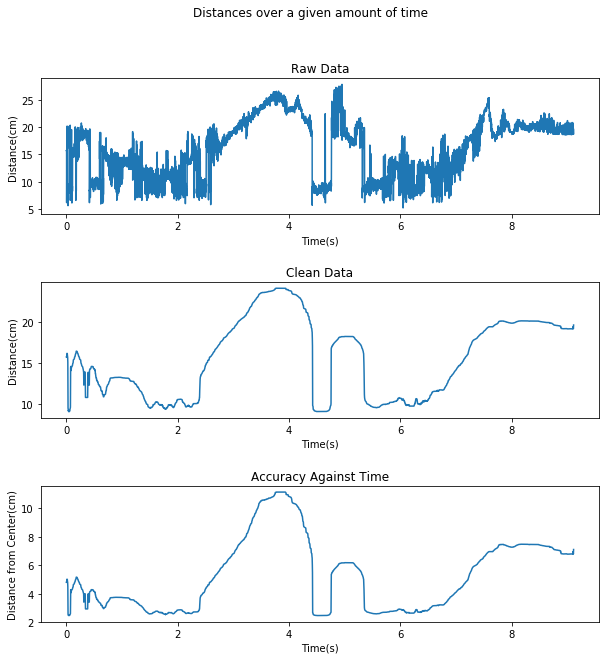

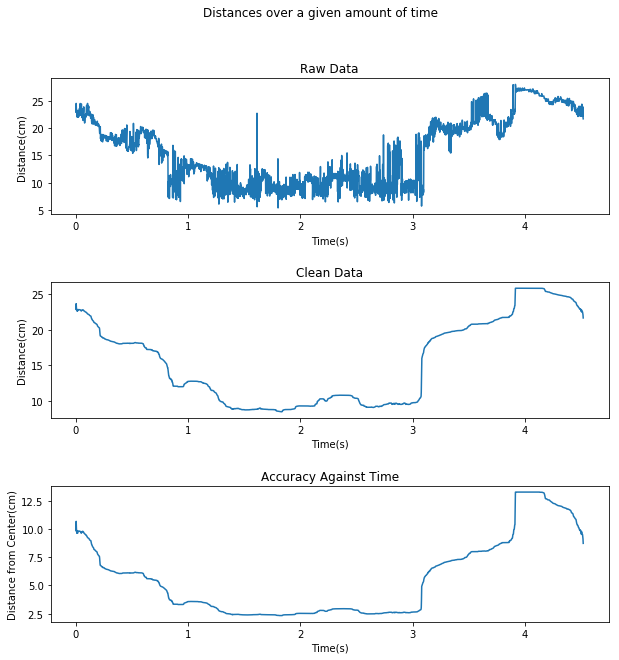

In [8]:
# MAIN

try:
    # Wait to start until the power button is pressed
    while GPIO.input(powerButtonPin) == 0:
        continue
        
    playSong('Can_You_Dig_It_Melody.npy', 'Can_You_Dig_It_Bass.npy', buzPin1, buzPin2, ledPin1, ledPin2)
    
    print("Ready to Fire")
    laserList = []
    
    # wait until we have finished firing shots
    while GPIO.input(powerButtonPin) == 0:
        # check if we are firing a laser
        if GPIO.input(firingButtonPin) == 1:
            playSong('shotHigh.npy', 'shotLow.npy', buzPin1, buzPin2, ledPin1, ledPin2)
            GPIO.output(ledPin1, True)
            GPIO.output(ledPin2, True)
            newLaser = LaserShot(trigPin, echoPin, firingButtonPin)
            newLaser.collectData()
            newLaser.cleanData()
            laserList.append(newLaser)
            GPIO.output(ledPin1, False)
            GPIO.output(ledPin2, False)
    
    # plot the data
    for shot in laserList:
        shot.plotData()

except(KeyboardInterrupt, SystemExit):
    print("Interrupt!")
finally:
    pi.stop()
    GPIO.cleanup()
